In [73]:
!pip install eli5
!pip install category_encoders
!pip install xgboost

In [74]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import metrics
import category_encoders as ce

In [75]:
# Load dataset
df = pd.read_csv('./heart.csv')

In [79]:
# Display first 10 rows with a color gradient
df.head(10).style.background_gradient(cmap="Reds")

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.000000,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.000000,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.000000,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.500000,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.000000,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.000000,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.000000,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.000000,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.500000,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.000000,Up,0


In [76]:
# Check for missing values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [77]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


<Axes: xlabel='HeartDisease', ylabel='count'>

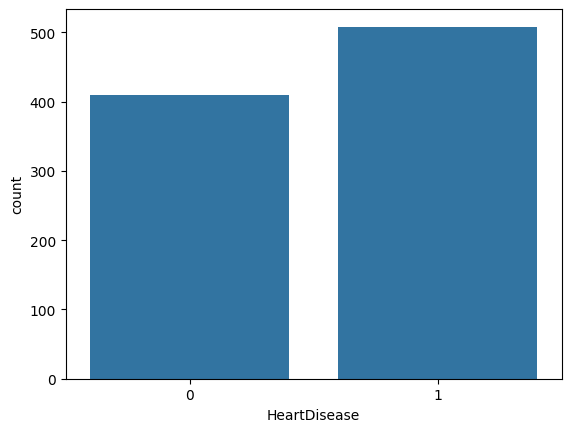

In [78]:
# Countplot for target variable
sns.countplot(x = df.HeartDisease)

In [80]:
# Normalize value counts of ST_Slope grouped by HeartDisease
df.groupby('HeartDisease')['ST_Slope'].value_counts(normalize = True)

HeartDisease  ST_Slope
0             Up          0.773171
              Flat        0.192683
              Down        0.034146
1             Flat        0.750000
              Up          0.153543
              Down        0.096457
Name: proportion, dtype: float64

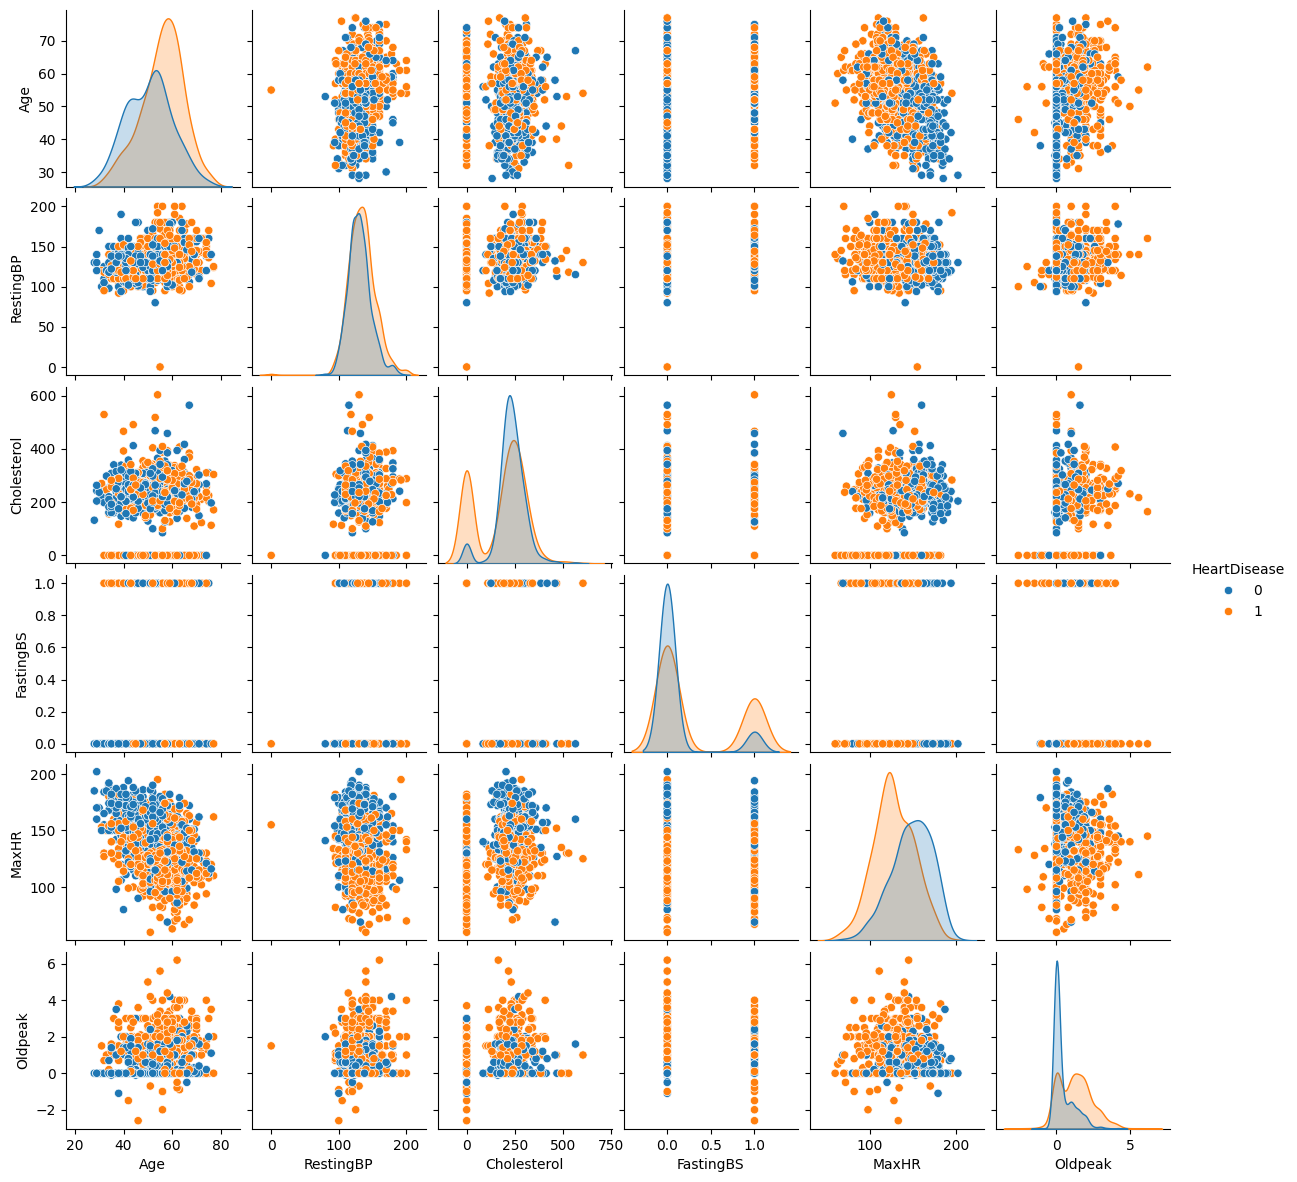

In [81]:
# Pairplot with hue as HeartDisease
sns.pairplot(df,hue = 'HeartDisease', height = 2)

In [82]:
# Identify rows with RestingBP = 0
df[df.RestingBP == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [83]:
# Drop invalid row
df.drop(index = 449, inplace = True)

In [84]:
# Encode ExerciseAngina
df["ExerciseAngina"] = df["ExerciseAngina"].apply(lambda x: 1 if x=="Y" else 0)

In [85]:
# Encode Sex
df.Sex = df.Sex =='M'
df.rename(columns = {'Sex':'Male'}, inplace = True)

In [86]:
# Target encoding for categorical features
encoder = ce.TargetEncoder()
features = ['ChestPainType', 'RestingECG', 'ST_Slope']
df[features] = encoder.fit_transform(df[features], df['HeartDisease'])

In [87]:
# Correlation matrix for HeartDisease
corr = df.corr().HeartDisease.sort_values(ascending=False)
corr = corr.to_frame()
corr.style.background_gradient(cmap="Reds")

,HeartDisease
HeartDisease,1.000000
ST_Slope,0.622334
ChestPainType,0.541500
ExerciseAngina,0.495490
Oldpeak,0.403638
Male,0.305118
Age,0.282012
FastingBS,0.267994
RestingBP,0.117990
RestingECG,0.109870


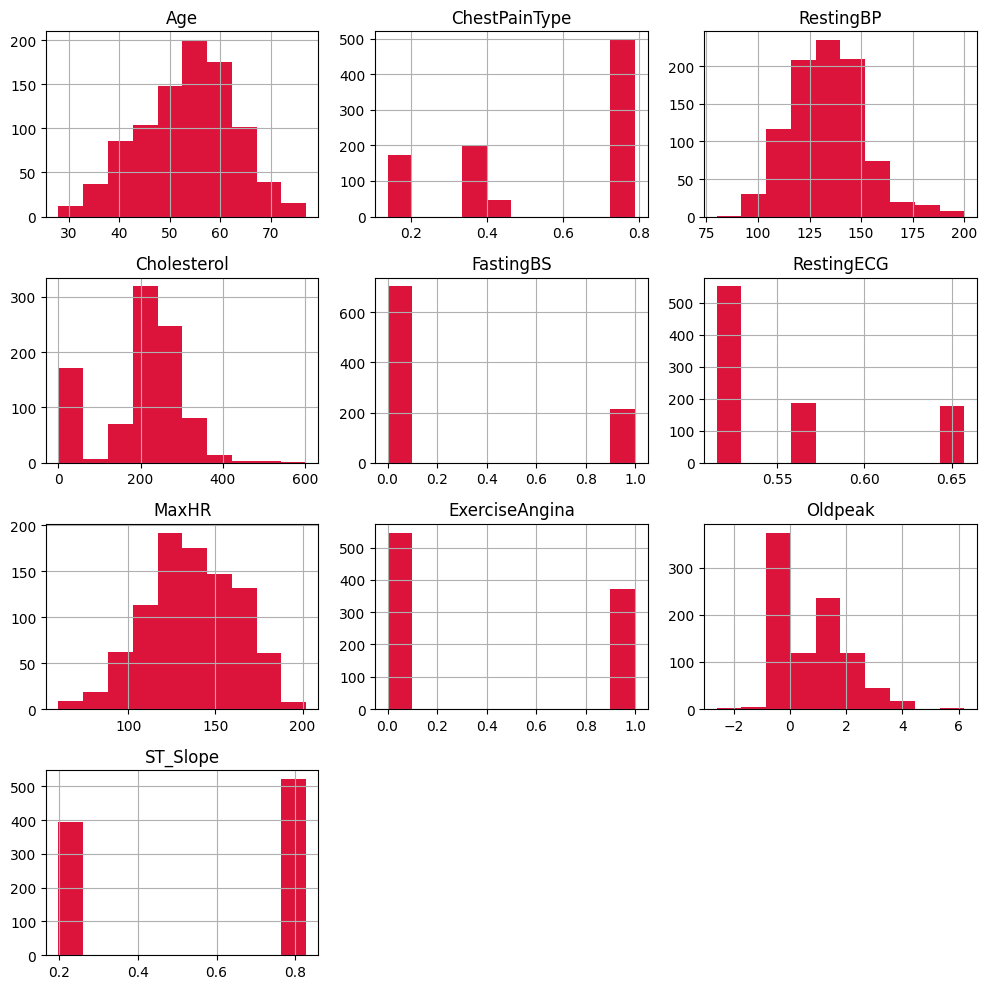

In [88]:
# Histograms of features
df.drop(columns='HeartDisease').hist(figsize=(10,10), grid=True, color='crimson')
plt.tight_layout()

In [89]:
# Define features and target
X = df.drop(columns='HeartDisease')
y = df['HeartDisease']

In [90]:
print("Features = ", [feature for feature in X.columns])
print('')
print("Number of features = ", len(X.columns))

Features =  ['Age', 'Male', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope']

Number of features =  11


In [91]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=67)


In [92]:
# XGBoost Classifier
clf_xgb = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05, use_label_encoder=False)
clf_xgb.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

clf_xgb = xgb.XGBClassifier(n_estimators=clf_xgb.best_iteration, random_state=73, use_label_encoder=False)
clf_xgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=82, n_jobs=None,
              num_parallel_tree=None, random_state=73, ...)

In [93]:
# Feature importance for XGBoost
feature_imp = pd.Series(clf_xgb.feature_importances_, index=X.columns).sort_values(ascending=False)
print(feature_imp)

ST_Slope          0.407729
ChestPainType     0.150037
Male              0.088563
ExerciseAngina    0.079276
FastingBS         0.060023
Oldpeak           0.045621
Cholesterol       0.041654
RestingBP         0.034681
MaxHR             0.032166
RestingECG        0.030278
Age               0.029971
dtype: float32


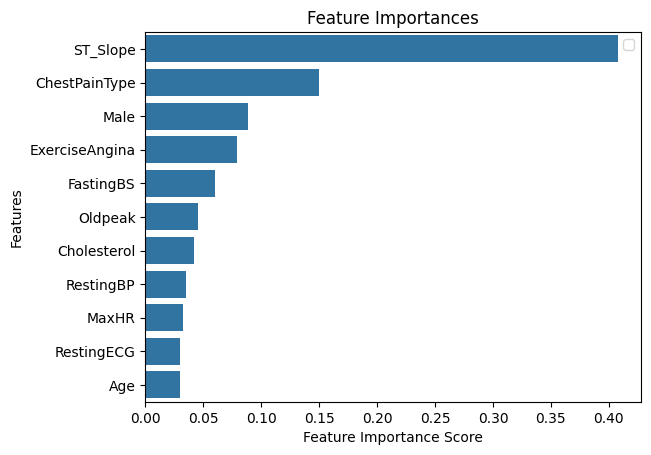

In [94]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Feature Importances")
plt.legend()
plt.show()

In [95]:
# Permutation importance for XGBoost
perm = PermutationImportance(clf_xgb, random_state=1).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=X_train.columns.tolist())

Weight,Feature
0.1613 ± 0.0265,ST_Slope
0.0684 ± 0.0124,ChestPainType
0.0594 ± 0.0120,Cholesterol
0.0544 ± 0.0142,Oldpeak
0.0422 ± 0.0092,RestingBP
0.0381 ± 0.0184,Male
0.0370 ± 0.0134,MaxHR
0.0344 ± 0.0104,Age
0.0207 ± 0.0085,FastingBS
0.0154 ± 0.0047,ExerciseAngina


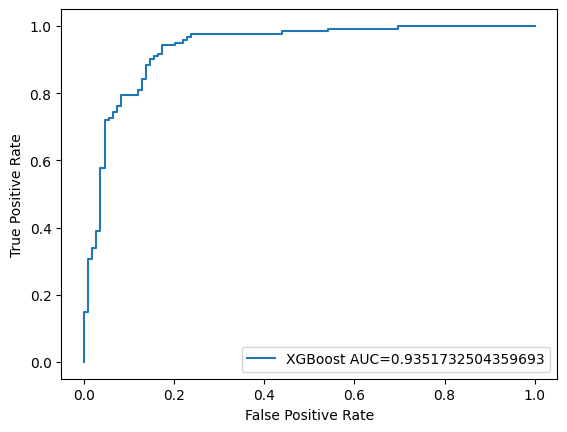

In [96]:
y_pred_proba_xgb = clf_xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test, y_pred_proba_xgb)
auc_xgb = metrics.roc_auc_score(y_test, y_pred_proba_xgb)

# roc curve with AUC score
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost AUC=" + str(auc_xgb))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()


In [97]:
# Logistic Regression
clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

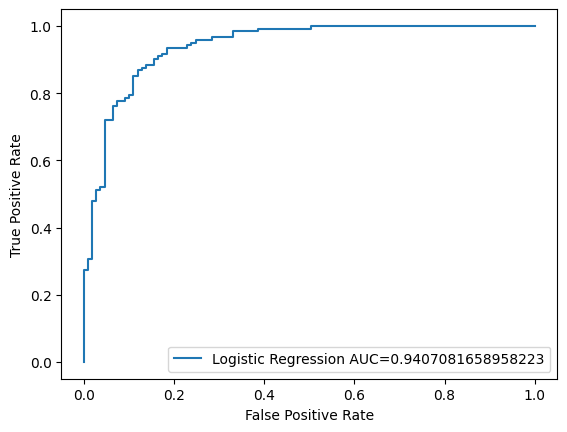

In [98]:
# ROC Curve and AUC for Logistic Regression
y_pred_proba_lr = clf_lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test, y_pred_proba_lr)
auc_lr = metrics.roc_auc_score(y_test, y_pred_proba_lr)

plt.plot(fpr_lr, tpr_lr, label="Logistic Regression AUC=" + str(auc_lr))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [99]:
# Accuracy scores for both models
print("XGBoost Classifier Accuracy:", clf_xgb.score(X_test, y_test).round(2))
print("Logistic Regression Accuracy:", clf_lr.score(X_test, y_test).round(2))

XGBoost Classifier Accuracy: 0.87
Logistic Regression Accuracy: 0.87
